In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer


%matplotlib inline

In [11]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
df = pd.read_csv('/content/drive/MyDrive/ЖКХ/готово.csv')

In [13]:
!pip install emoji
import emoji

for index, row in enumerate(df['текст']):
  df['текст'] = df['текст'].replace(df['текст'][index], (emoji.demojize(df['текст'][index], language='ru')))

In [14]:
category = df['категория'].value_counts()
emotion = df['эмоция'].value_counts()
urgency = df['срочность'].value_counts()

In [15]:
print("Размер датасета:", len(df))
print("\nРаспределение категорий:")
print(category)
print("\nРаспределение эмоций:")
print(emotion)
print("\nРаспределение срочности:")
print(urgency)

Размер датасета: 6130

Распределение категорий:
категория
ремонт          626
двор            617
уборка          597
вода            594
мусор           569
электрика       564
отопление       537
безопасность    531
лифт            521
канализация     487
лишнее          487
Name: count, dtype: int64

Распределение эмоций:
эмоция
гнев             2204
разочарование    1203
тревога          1199
нейтральная       752
надежда           525
сарказм           247
Name: count, dtype: int64

Распределение срочности:
срочность
средняя        1704
высокая        1303
критическая    1134
низкая         1067
нулевая         922
Name: count, dtype: int64



СТАТИСТИКА ПО ОСНОВНЫМ ГРУППАМ:
 1. ремонт                    |  626 жалоб |  10.2%
 2. двор                      |  617 жалоб |  10.1%
 3. уборка                    |  597 жалоб |   9.7%
 4. вода                      |  594 жалоб |   9.7%
 5. мусор                     |  569 жалоб |   9.3%
 6. электрика                 |  564 жалоб |   9.2%
 7. отопление                 |  537 жалоб |   8.8%
 8. безопасность              |  531 жалоб |   8.7%
 9. лифт                      |  521 жалоб |   8.5%
10. канализация               |  487 жалоб |   7.9%
11. лишнее                    |  487 жалоб |   7.9%

Всего жалоб: 6130
Количество категорий: 11

СТАТИСТИКА ПО ОСНОВНЫМ ГРУППАМ:
 1. гнев                      | 2204 жалоб |  36.0%
 2. разочарование             | 1203 жалоб |  19.6%
 3. тревога                   | 1199 жалоб |  19.6%
 4. нейтральная               |  752 жалоб |  12.3%
 5. надежда                   |  525 жалоб |   8.6%
 6. сарказм                   |  247 жалоб |   4.0%

Всего

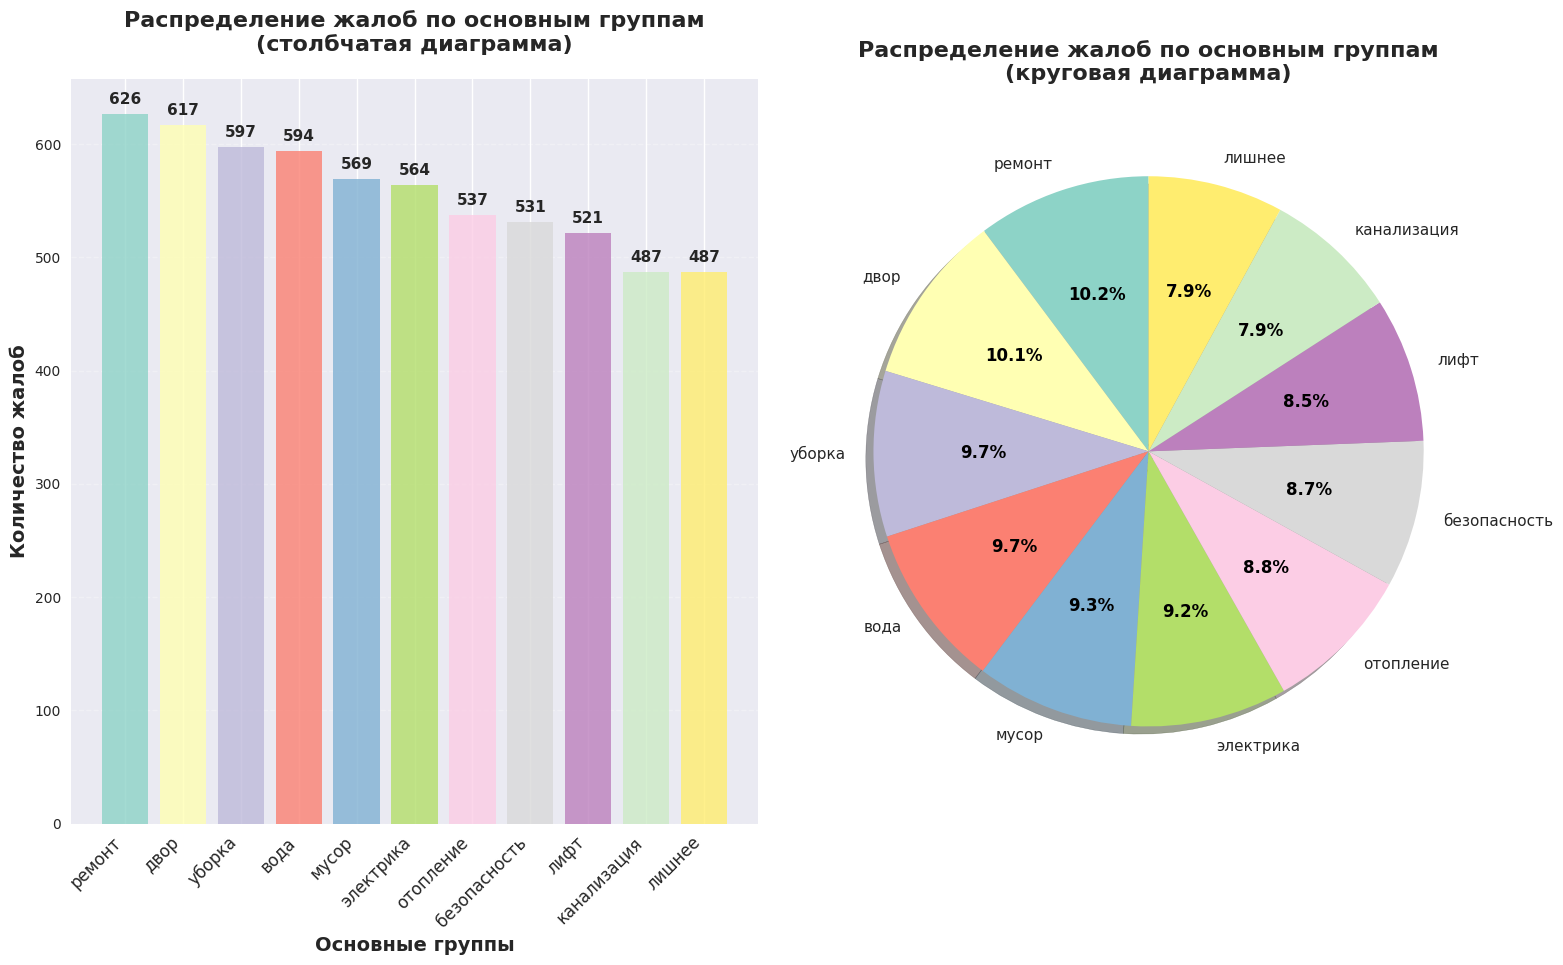

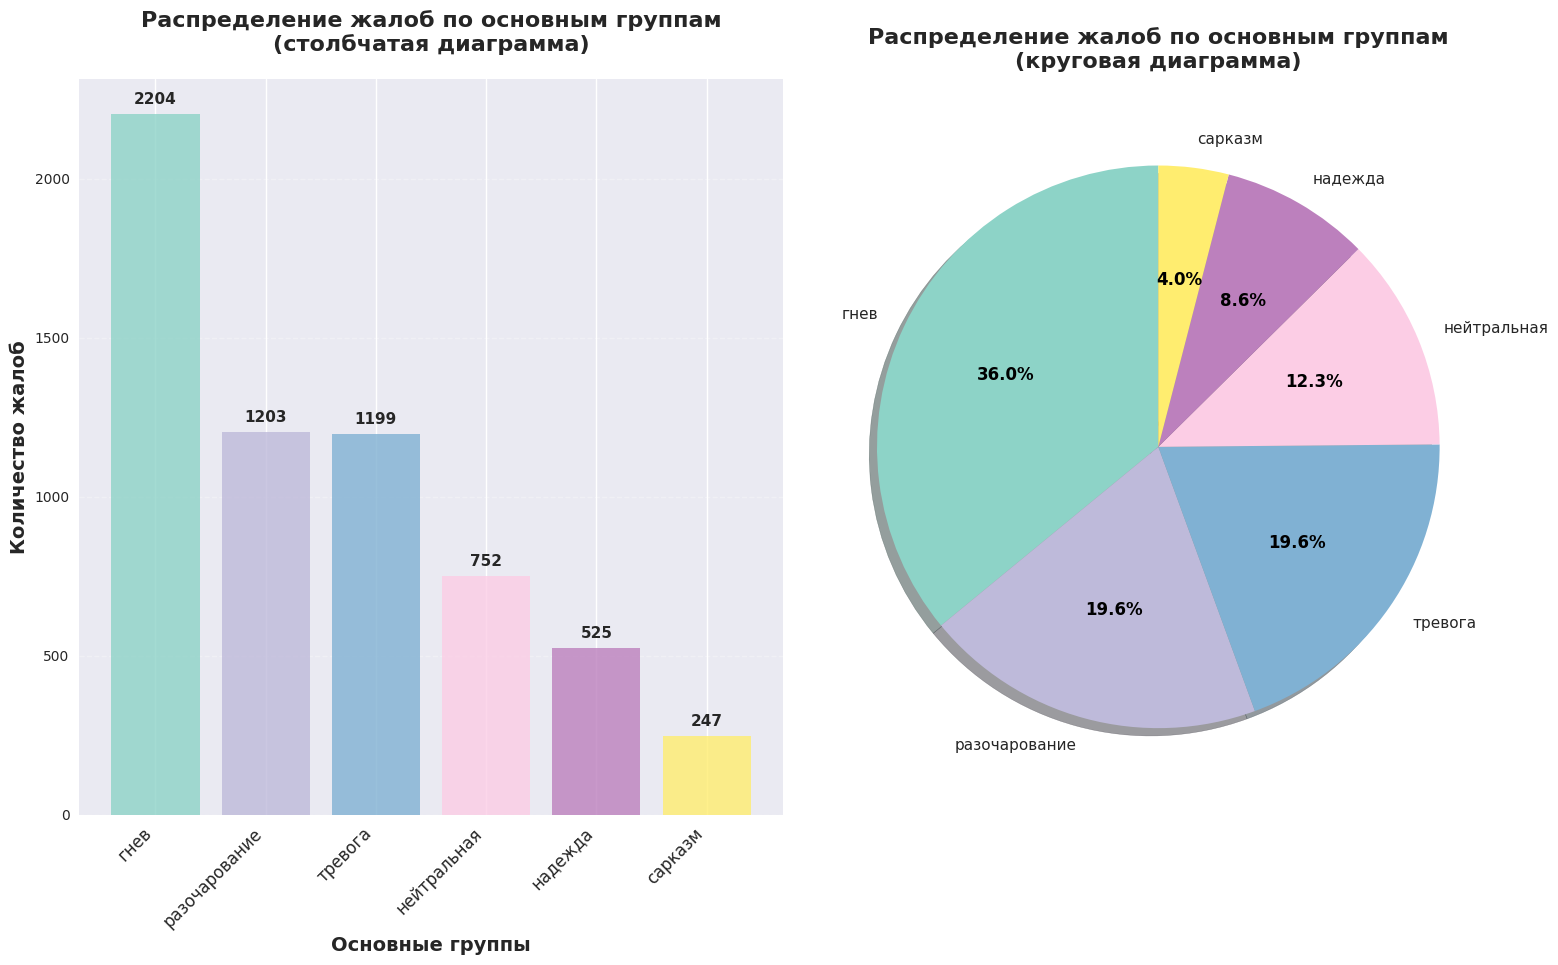

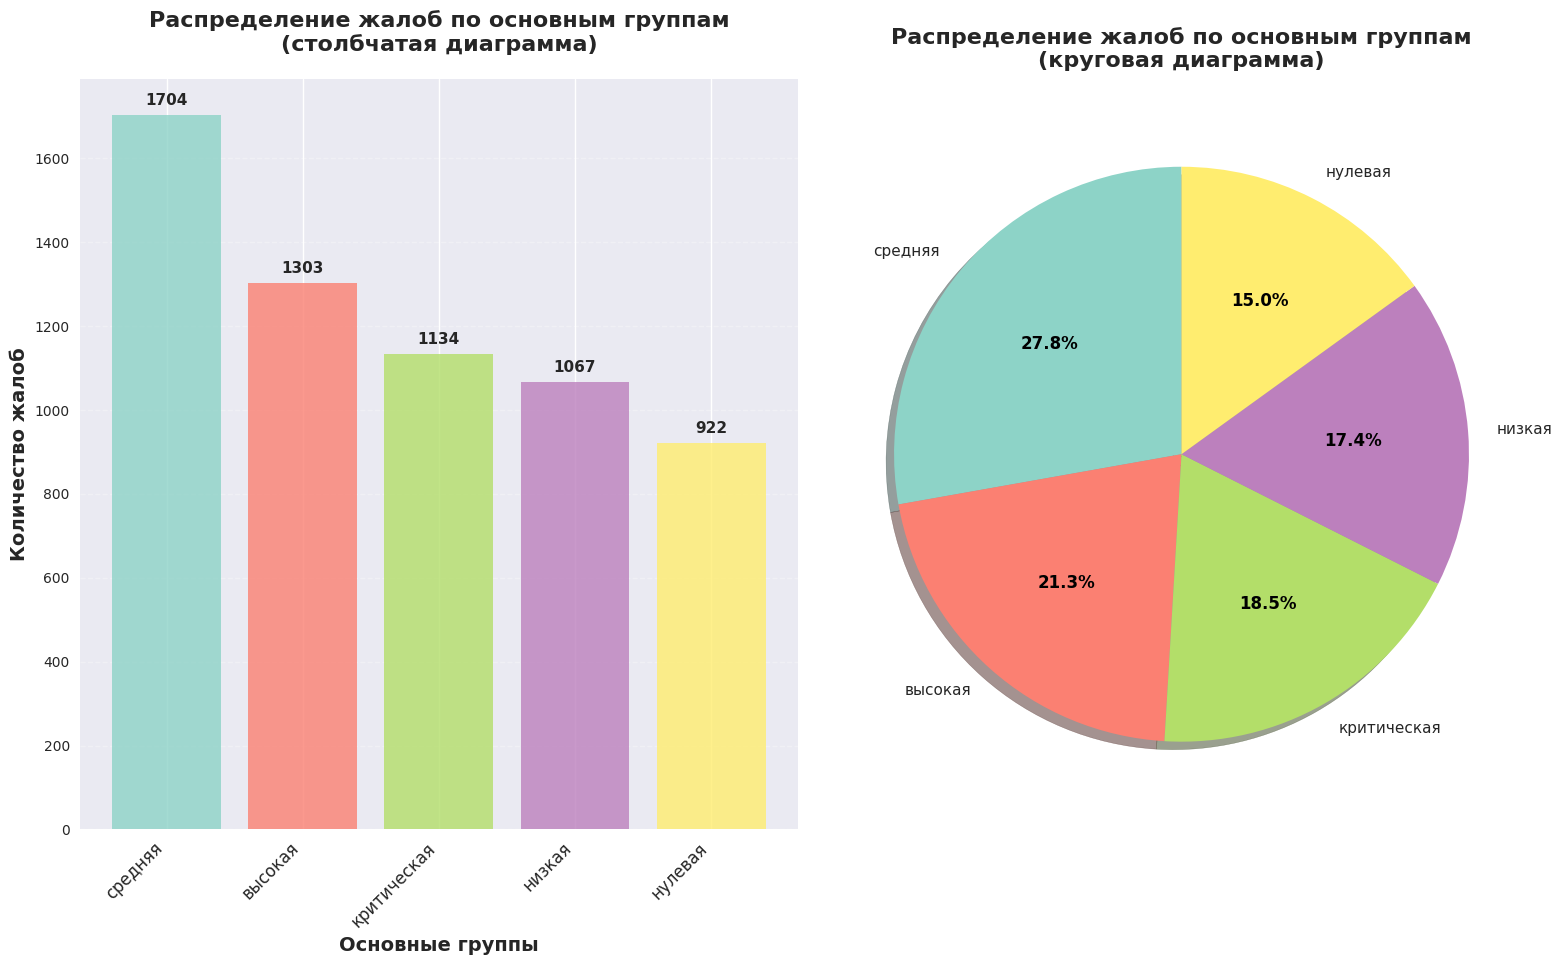

In [16]:
from matplotlib import rcParams

# Устанавливка стиля
plt.style.use('seaborn-v0_8')
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 18

def plot_main_group_distribution(main_group_series, figsize=(16, 10)):
    """
    Улучшенная визуализация распределения основных групп жалоб

    Parameters:
    main_group_series: pd.Series с value_counts() для main_group
    figsize: tuple - размер фигуры
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    russian_names = {
        'water_systems': 'Водные системы',
        'electricity': 'Электричество',
        'heating_ventilation': 'Отопление и вентиляция',
        'elevators': 'Лифты',
        'waste_cleaning': 'Мусор и уборка',
        'building_structures': 'Конструкции здания',
        'amenities': 'Благоустройство',
        'safety_security': 'Безопасность'
    }
    main_group_russian = main_group_series.rename(index=russian_names)

    # Bar plot
    colors = plt.cm.Set3(np.linspace(0, 1, len(main_group_russian)))
    bars = ax1.bar(range(len(main_group_russian)), main_group_russian.values, color=colors, alpha=0.8)

    ax1.set_title('Распределение жалоб по основным группам\n(столбчатая диаграмма)',
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Основные группы', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Количество жалоб', fontsize=14, fontweight='bold')


    ax1.set_xticks(range(len(main_group_russian)))
    ax1.set_xticklabels(main_group_russian.index, rotation=45, ha='right', fontsize=12)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(main_group_russian.values)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)

    # Pie chart
    explode = [0.05 if value < max(main_group_russian.values) * 0.1 else 0 for value in main_group_russian.values]

    wedges, texts, autotexts = ax2.pie(main_group_russian.values,
                                      labels=main_group_russian.index,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=colors,
                                      explode=explode,
                                      shadow=True,
                                      textprops={'fontsize': 11})

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)

    for text in texts:
        text.set_fontsize(11)

    ax2.set_title('Распределение жалоб по основным группам\n(круговая диаграмма)',
                  fontsize=16, fontweight='bold', pad=20)

    fig.subplots_adjust(top=0.85)
    plt.tight_layout(rect=[0, 0, 1, 0.85])
    plt.subplots_adjust(top=0.9)

    print("\n" + "="*60)
    print("СТАТИСТИКА ПО ОСНОВНЫМ ГРУППАМ:")
    print("="*60)
    total_complaints = main_group_series.sum()
    for i, (group, count) in enumerate(main_group_russian.items(), 1):
        percentage = (count / total_complaints) * 100
        print(f"{i:2d}. {group:25} | {count:4d} жалоб | {percentage:5.1f}%")

    print(f"\nВсего жалоб: {total_complaints}")
    print(f"Количество категорий: {len(main_group_series)}")

plot_main_group_distribution(category)
plot_main_group_distribution(emotion)
plot_main_group_distribution(urgency)

In [17]:
!pip install iterative-stratification

In [18]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

def prepare_multilabel_stratification(df, test_size=0.2, val_size=0.1, random_state=42):
    lb_category = LabelBinarizer()
    lb_emotion = LabelBinarizer()
    lb_urgency = LabelBinarizer()

    category_onehot = lb_category.fit_transform(df['категория'])
    emotion_onehot = lb_emotion.fit_transform(df['эмоция'])
    urgency_onehot = lb_urgency.fit_transform(df['срочность'])
    y_multitask = np.concatenate([category_onehot, emotion_onehot, urgency_onehot], axis=1)

    print(f"Размерность многометочного вектора: {y_multitask.shape}")
    print(f"Категории: {lb_category.classes_}")
    print(f"Эмоции: {lb_emotion.classes_}")
    print(f"Срочность: {lb_urgency.classes_}")

    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    indices = np.arange(len(df))
    for train_val_idx, test_idx in mskf.split(indices, y_multitask):
        train_val_df = df.iloc[train_val_idx]
        test_df = df.iloc[test_idx]
        break

    category_onehot_val = lb_category.transform(train_val_df['категория'])
    emotion_onehot_val = lb_emotion.transform(train_val_df['эмоция'])
    urgency_onehot_val = lb_urgency.transform(train_val_df['срочность'])

    y_multitask_val = np.concatenate([category_onehot_val, emotion_onehot_val, urgency_onehot_val], axis=1)

    train_val_indices = np.arange(len(train_val_df))
    for train_idx, val_idx in mskf.split(train_val_indices, y_multitask_val):
        train_df = train_val_df.iloc[train_idx]
        val_df = train_val_df.iloc[val_idx]
        break

    result = {
        'train': train_df,
        'val': val_df,
        'test': test_df,
        'encoders': {
            'category': lb_category,
            'emotion': lb_emotion,
            'urgency': lb_urgency
        }
    }

    return result

stratification_result = prepare_multilabel_stratification(df)

Размерность многометочного вектора: (6130, 22)
Категории: ['безопасность' 'вода' 'двор' 'канализация' 'лифт' 'лишнее' 'мусор'
 'отопление' 'ремонт' 'уборка' 'электрика']
Эмоции: ['гнев' 'надежда' 'нейтральная' 'разочарование' 'сарказм' 'тревога']
Срочность: ['высокая' 'критическая' 'низкая' 'нулевая' 'средняя']


In [19]:
def check_stratification_quality(result):
    """Проверяет качество стратификации"""

    train_df = result['train']
    val_df = result['val']
    test_df = result['test']

    print("=" * 50)
    print("ПРОВЕРКА СТРАТИФИКАЦИИ")
    print("=" * 50)

    for split_name, split_df in [('TRAIN', train_df), ('VAL', val_df), ('TEST', test_df)]:
        print(f"\n{split_name} ({len(split_df)} записей):")

        # Категории
        cat_dist = split_df['категория'].value_counts(normalize=True)
        print("  Категории:")
        for cat, perc in cat_dist.items():
            print(f"    {cat}: {perc:.1%}")

        # Эмоции
        emo_dist = split_df['эмоция'].value_counts(normalize=True)
        print("  Эмоции:")
        for emo, perc in emo_dist.items():
            print(f"    {emo}: {perc:.1%}")

        # Срочность
        urg_dist = split_df['срочность'].value_counts(normalize=True)
        print("  Срочность:")
        for urg, perc in urg_dist.items():
            print(f"    {urg}: {perc:.1%}")

check_stratification_quality(stratification_result)

ПРОВЕРКА СТРАТИФИКАЦИИ

TRAIN (3922 записей):
  Категории:
    ремонт: 10.2%
    двор: 10.1%
    уборка: 9.8%
    вода: 9.7%
    мусор: 9.3%
    электрика: 9.2%
    отопление: 8.8%
    безопасность: 8.6%
    лифт: 8.5%
    канализация: 8.0%
    лишнее: 7.9%
  Эмоции:
    гнев: 35.9%
    разочарование: 19.6%
    тревога: 19.6%
    нейтральная: 12.3%
    надежда: 8.6%
    сарказм: 4.1%
  Срочность:
    средняя: 27.8%
    высокая: 21.3%
    критическая: 18.5%
    низкая: 17.4%
    нулевая: 15.0%

VAL (981 записей):
  Категории:
    ремонт: 10.2%
    двор: 10.1%
    уборка: 9.9%
    вода: 9.7%
    мусор: 9.3%
    электрика: 9.2%
    безопасность: 8.7%
    отопление: 8.7%
    лифт: 8.5%
    канализация: 8.0%
    лишнее: 8.0%
  Эмоции:
    гнев: 36.1%
    разочарование: 19.7%
    тревога: 19.5%
    нейтральная: 12.2%
    надежда: 8.6%
    сарказм: 4.0%
  Срочность:
    средняя: 27.7%
    высокая: 21.3%
    критическая: 18.5%
    низкая: 17.4%
    нулевая: 15.1%

TEST (1227 записей):
  Катего

In [20]:
stratified_category = stratification_result['train']['категория'].value_counts()
stratified_emotion = stratification_result['train']['эмоция'].value_counts()
stratified_urgency = stratification_result['train']['срочность'].value_counts()


СТАТИСТИКА ПО ОСНОВНЫМ ГРУППАМ:
 1. ремонт                    |  400 жалоб |  10.2%
 2. двор                      |  395 жалоб |  10.1%
 3. уборка                    |  383 жалоб |   9.8%
 4. вода                      |  380 жалоб |   9.7%
 5. мусор                     |  364 жалоб |   9.3%
 6. электрика                 |  361 жалоб |   9.2%
 7. отопление                 |  344 жалоб |   8.8%
 8. безопасность              |  339 жалоб |   8.6%
 9. лифт                      |  333 жалоб |   8.5%
10. канализация               |  312 жалоб |   8.0%
11. лишнее                    |  311 жалоб |   7.9%

Всего жалоб: 3922
Количество категорий: 11

СТАТИСТИКА ПО ОСНОВНЫМ ГРУППАМ:
 1. гнев                      | 1409 жалоб |  35.9%
 2. разочарование             |  769 жалоб |  19.6%
 3. тревога                   |  768 жалоб |  19.6%
 4. нейтральная               |  481 жалоб |  12.3%
 5. надежда                   |  336 жалоб |   8.6%
 6. сарказм                   |  159 жалоб |   4.1%

Всего

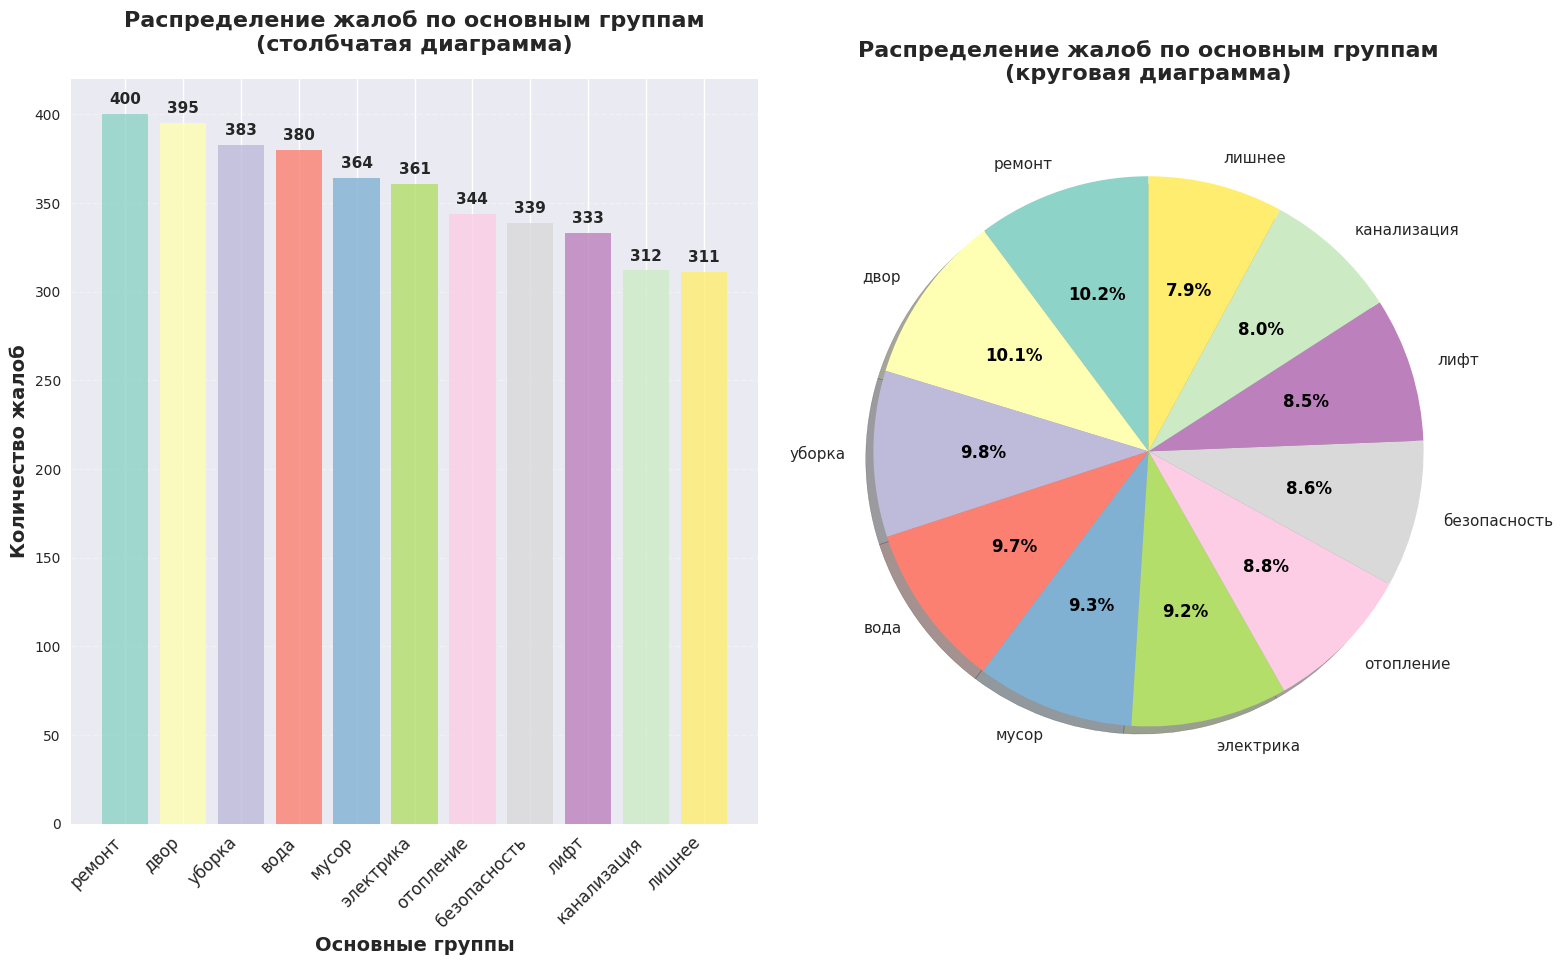

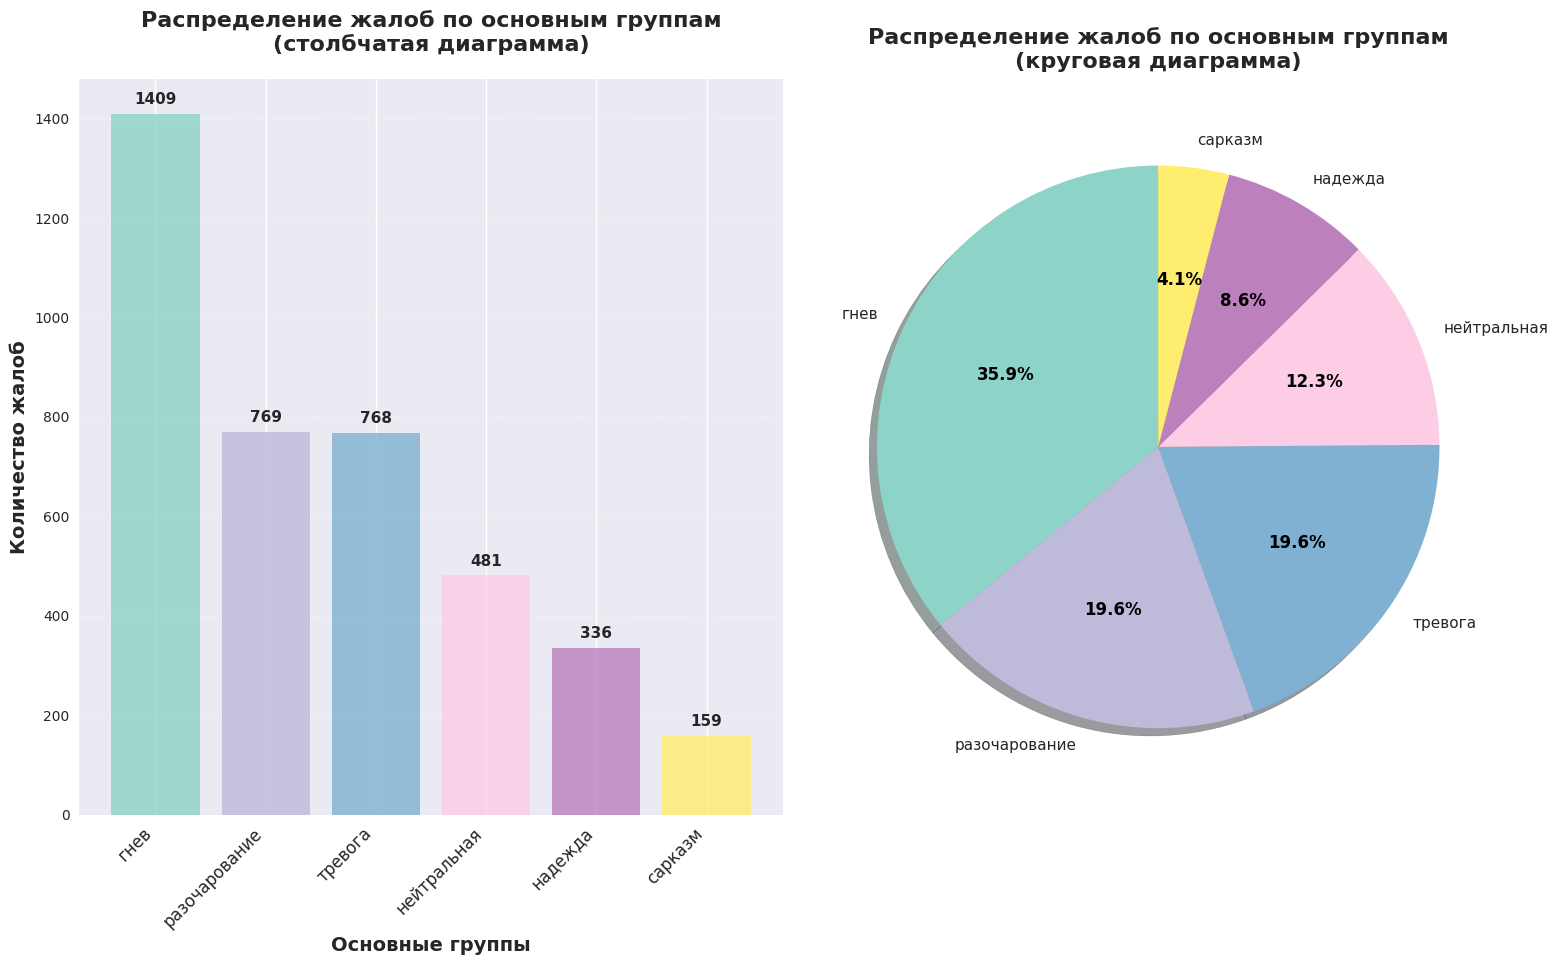

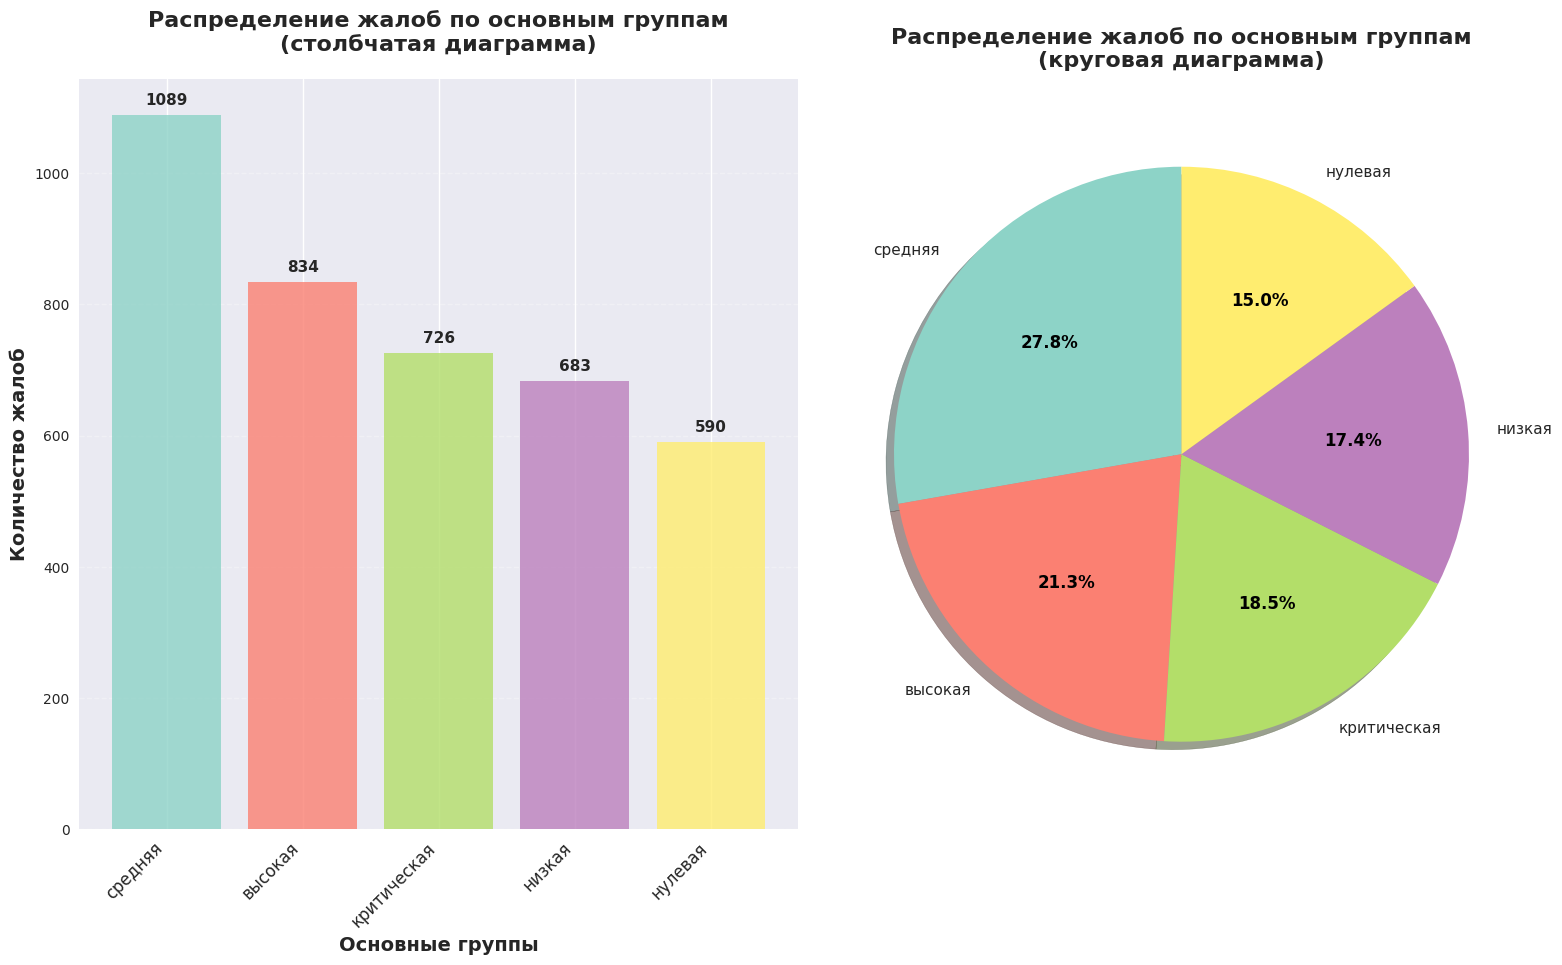

In [21]:
plot_main_group_distribution(stratified_category)
plot_main_group_distribution(stratified_emotion)
plot_main_group_distribution(stratified_urgency)

In [22]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

class MultiTaskDataset(Dataset):
    def __init__(self, texts, categories, emotions, urgencies, tokenizer, max_length=512):
        self.texts = texts
        self.categories = categories
        self.emotions = emotions
        self.urgencies = urgencies
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        # Токенизация текста
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Получаем индексы классов из кодировщиков
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'category_labels': torch.tensor(self.categories[idx]),
            'emotion_labels': torch.tensor(self.emotions[idx]),
            'urgency_labels': torch.tensor(self.urgencies[idx])
        }
        return item

    def __len__(self):
        return len(self.texts)

In [23]:


def prepare_datasets(result, tokenizer_name='cointegrated/rubert-tiny2'):
    """Подготавливает датасеты для обучения"""

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    lb_category = result['encoders']['category']
    lb_emotion = result['encoders']['emotion']
    lb_urgency = result['encoders']['urgency']

    def prepare_split(df):
        category_indices = lb_category.transform(df['категория']).argmax(axis=1)
        emotion_indices = lb_emotion.transform(df['эмоция']).argmax(axis=1)
        urgency_indices = lb_urgency.transform(df['срочность']).argmax(axis=1)

        return MultiTaskDataset(
            texts=df['текст'].tolist(),
            categories=category_indices,
            emotions=emotion_indices,
            urgencies=urgency_indices,
            tokenizer=tokenizer
        )

    train_dataset = prepare_split(result['train'])
    val_dataset = prepare_split(result['val'])
    test_dataset = prepare_split(result['test'])

    return {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset,
        'encoders': result['encoders'],
        'num_categories': len(lb_category.classes_),
        'num_emotions': len(lb_emotion.classes_),
        'num_urgencies': len(lb_urgency.classes_)
    }

datasets = prepare_datasets(stratification_result)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [24]:
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel

class SimpleMultiTaskBERT(BertPreTrainedModel):
    def __init__(self, config, num_categories, num_emotions, num_urgencies):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.8)

        self.category_dropout = nn.Dropout(0.9)

        self.classifier_category = nn.Linear(config.hidden_size, num_categories)
        self.classifier_emotion = nn.Linear(config.hidden_size, num_emotions)
        self.classifier_urgency = nn.Linear(config.hidden_size, num_urgencies)

    def forward(self, input_ids=None, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]

        category_output = self.category_dropout(pooled_output)
        emotion_output = self.dropout(pooled_output)
        urgency_output = self.dropout(pooled_output)

        category_logits = self.classifier_category(category_output)
        emotion_logits = self.classifier_emotion(emotion_output)
        urgency_logits = self.classifier_urgency(urgency_output)

        return {
            'category_logits': category_logits,
            'emotion_logits': emotion_logits,
            'urgency_logits': urgency_logits
        }

In [25]:
from transformers import AutoConfig

# Параметры модели
model_name = 'cointegrated/rubert-tiny2'
config = AutoConfig.from_pretrained(model_name)

model = SimpleMultiTaskBERT.from_pretrained(
    model_name,
    config=config,
    num_categories=datasets['num_categories'],
    num_emotions=datasets['num_emotions'],
    num_urgencies=datasets['num_urgencies']
)

print(f"Модель создана с параметрами:")
print(f"- Категории: {datasets['num_categories']} классов")
print(f"- Эмоции: {datasets['num_emotions']} классов")
print(f"- Срочность: {datasets['num_urgencies']} классов")

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of SimpleMultiTaskBERT were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier_category.bias', 'classifier_category.weight', 'classifier_emotion.bias', 'classifier_emotion.weight', 'classifier_urgency.bias', 'classifier_urgency.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель создана с параметрами:
- Категории: 11 классов
- Эмоции: 6 классов
- Срочность: 5 классов


In [26]:
from transformers import AutoConfig, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_dataloader = DataLoader(datasets['train'], batch_size=16, shuffle=True)
valid_dataloader = DataLoader(datasets['val'], batch_size=16)    # validation
test_dataloader = DataLoader(datasets['test'], batch_size=16)    # test (не используется при обучении)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,
    weight_decay=0.01
)

total_steps = len(train_dataloader) * 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps
)

def compute_accuracy(logits, labels):
    predictions = torch.argmax(logits, dim=1)
    correct = (predictions == labels).float().sum()
    return correct / len(labels)

def compute_balanced_loss(outputs, category_labels, emotion_labels, urgency_labels):
    loss_fct = torch.nn.CrossEntropyLoss()

    loss_category = loss_fct(outputs['category_logits'], category_labels)
    loss_emotion = loss_fct(outputs['emotion_logits'], emotion_labels)
    loss_urgency = loss_fct(outputs['urgency_logits'], urgency_labels)

    category_probs = torch.softmax(outputs['category_logits'], dim=1)
    category_entropy = -torch.sum(category_probs * torch.log(category_probs + 1e-8), dim=1).mean()

    entropy_penalty = -0.1 * category_entropy

    return loss_category + loss_emotion + loss_urgency + entropy_penalty

model.train()
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(8):
    total_loss = 0
    total_category_acc = 0
    total_emotion_acc = 0
    total_urgency_acc = 0

    for batch_idx, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        category_labels = batch['category_labels'].to(device)  # ИЗМЕНИЛИ С main на category
        emotion_labels = batch['emotion_labels'].to(device)
        urgency_labels = batch['urgency_labels'].to(device)

        optimizer.zero_grad()

        # Forward pass (Без вычисления loss в модели)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask

        )

        # loss с балансировкой
        loss = compute_balanced_loss(outputs, category_labels, emotion_labels, urgency_labels)

        loss.backward()
        for name, param in model.named_parameters():
            if 'classifier_category' in name and param.grad is not None:
                param.grad = param.grad * 0.5
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()

        # метрики
        total_loss += loss.item()
        total_category_acc += compute_accuracy(outputs['category_logits'], category_labels).item()
        total_emotion_acc += compute_accuracy(outputs['emotion_logits'], emotion_labels).item()
        total_urgency_acc += compute_accuracy(outputs['urgency_logits'], urgency_labels).item()

        if batch_idx % 50 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            avg_category_acc = total_category_acc / (batch_idx + 1)
            avg_emotion_acc = total_emotion_acc / (batch_idx + 1)
            avg_urgency_acc = total_urgency_acc / (batch_idx + 1)

            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, '
                  f'Loss: {avg_loss:.4f}, '
                  f'Category Acc: {avg_category_acc:.4f}, '
                  f'Emotion Acc: {avg_emotion_acc:.4f}, '
                  f'Urgency Acc: {avg_urgency_acc:.4f}')

    # ВАЛИДАЦИЯ
    model.eval()
    val_loss = 0
    val_category_acc = 0
    val_emotion_acc = 0
    val_urgency_acc = 0

    with torch.no_grad():
        for val_batch in valid_dataloader:
            input_ids = val_batch['input_ids'].to(device)
            attention_mask = val_batch['attention_mask'].to(device)
            category_labels = val_batch['category_labels'].to(device)
            emotion_labels = val_batch['emotion_labels'].to(device)
            urgency_labels = val_batch['urgency_labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # loss для валидации
            loss = compute_balanced_loss(outputs, category_labels, emotion_labels, urgency_labels)

            val_loss += loss.item()
            val_category_acc += compute_accuracy(outputs['category_logits'], category_labels).item()
            val_emotion_acc += compute_accuracy(outputs['emotion_logits'], emotion_labels).item()
            val_urgency_acc += compute_accuracy(outputs['urgency_logits'], urgency_labels).item()

    val_loss /= len(valid_dataloader)
    val_category_acc /= len(valid_dataloader)
    val_emotion_acc /= len(valid_dataloader)
    val_urgency_acc /= len(valid_dataloader)

    print(f'\n=== Epoch {epoch+1} Validation ===')
    print(f'Val Loss: {val_loss:.4f}')
    print(f'Val Category Acc: {val_category_acc:.4f}')
    print(f'Val Emotion Acc: {val_emotion_acc:.4f}')
    print(f'Val Urgency Acc: {val_urgency_acc:.4f}\n')

    # РАННЯЯ ОСТАНОВКА
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # лучшая модель
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ Сохранена лучшая модель с val_loss: {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"⚠️ Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("🛑 Ранняя остановка!")
            break

    # Возвращаем модель в режим обучения
    model.train()

# ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ
print("\n=== ФИНАЛЬНОЕ ТЕСТИРОВАНИЕ ===")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_category_acc = 0
test_emotion_acc = 0
test_urgency_acc = 0

with torch.no_grad():
    for test_batch in test_dataloader:
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        category_labels = test_batch['category_labels'].to(device)
        emotion_labels = test_batch['emotion_labels'].to(device)
        urgency_labels = test_batch['urgency_labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        test_category_acc += compute_accuracy(outputs['category_logits'], category_labels).item()
        test_emotion_acc += compute_accuracy(outputs['emotion_logits'], emotion_labels).item()
        test_urgency_acc += compute_accuracy(outputs['urgency_logits'], urgency_labels).item()

test_category_acc /= len(test_dataloader)
test_emotion_acc /= len(test_dataloader)
test_urgency_acc /= len(test_dataloader)

print(f"🎯 Финальные результаты на TEST данных:")
print(f"Test Category Acc: {test_category_acc:.4f}")
print(f"Test Emotion Acc: {test_emotion_acc:.4f}")
print(f"Test Urgency Acc: {test_urgency_acc:.4f}")

Epoch: 1, Batch: 0, Loss: 5.4886, Category Acc: 0.0625, Emotion Acc: 0.3125, Urgency Acc: 0.1875
Epoch: 1, Batch: 50, Loss: 5.5960, Category Acc: 0.0797, Emotion Acc: 0.1471, Urgency Acc: 0.1777
Epoch: 1, Batch: 100, Loss: 5.5871, Category Acc: 0.0897, Emotion Acc: 0.1665, Urgency Acc: 0.1813
Epoch: 1, Batch: 150, Loss: 5.5724, Category Acc: 0.0923, Emotion Acc: 0.1954, Urgency Acc: 0.1983
Epoch: 1, Batch: 200, Loss: 5.5558, Category Acc: 0.1017, Emotion Acc: 0.2313, Urgency Acc: 0.2068

=== Epoch 1 Validation ===
Val Loss: 5.4408
Val Category Acc: 0.2109
Val Emotion Acc: 0.3569
Val Urgency Acc: 0.2786

✅ Сохранена лучшая модель с val_loss: 5.4408
Epoch: 2, Batch: 0, Loss: 5.5000, Category Acc: 0.1250, Emotion Acc: 0.3125, Urgency Acc: 0.2500
Epoch: 2, Batch: 50, Loss: 5.4540, Category Acc: 0.1152, Emotion Acc: 0.3407, Urgency Acc: 0.2390
Epoch: 2, Batch: 100, Loss: 5.4355, Category Acc: 0.1250, Emotion Acc: 0.3558, Urgency Acc: 0.2500
Epoch: 2, Batch: 150, Loss: 5.4259, Category Acc: 


📈 ПОСТРОЕНИЕ ГРАФИКА МЕТРИК


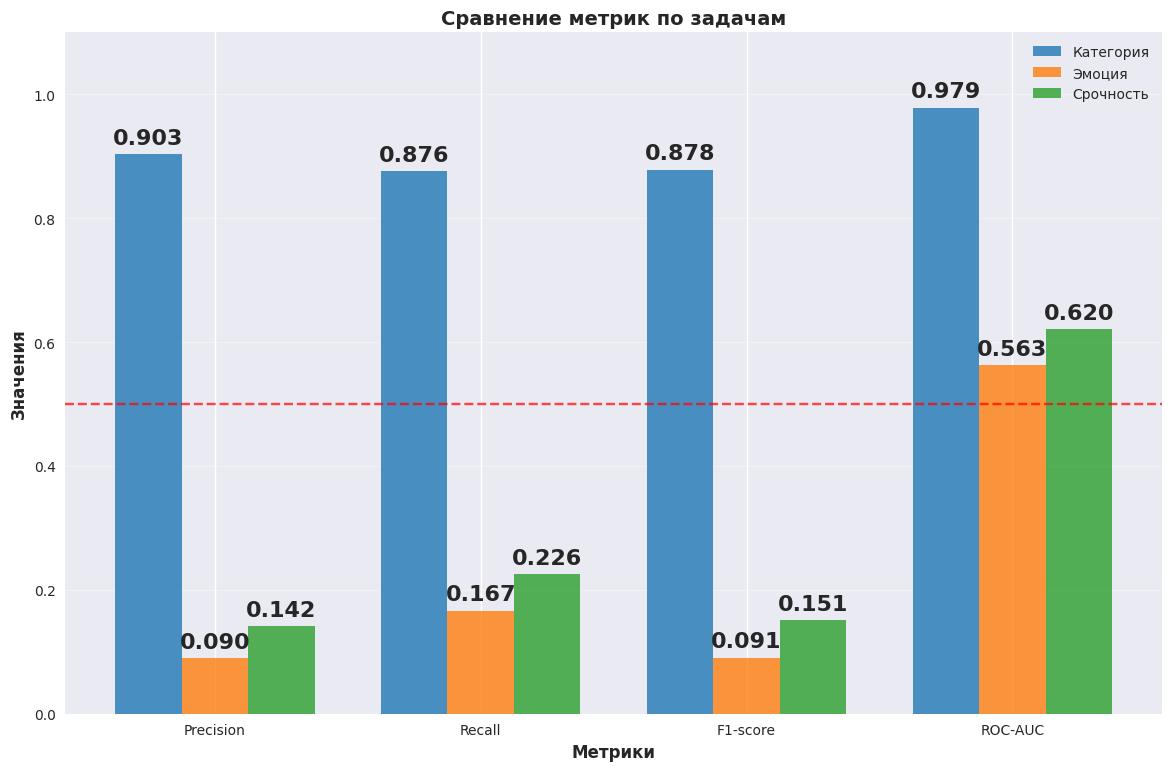


📊 ЧИСЛЕННЫЕ ЗНАЧЕНИЯ МЕТРИК:

КАТЕГОРИЯ:
  Precision: 0.9030
  Recall:    0.8760
  F1-score:  0.8784
  ROC-AUC:   0.9785

ЭМОЦИЯ:
  Precision: 0.0902
  Recall:    0.1665
  F1-score:  0.0906
  ROC-AUC:   0.5632

СРОЧНОСТЬ:
  Precision: 0.1420
  Recall:    0.2260
  F1-score:  0.1508
  ROC-AUC:   0.6204

✅ График метрик построен!


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch

def compute_metrics_for_task(logits, labels, num_classes):
    """Вычисляет все метрики для одной задачи"""
    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()
    true_labels = labels.cpu().numpy()

    # Для многоклассовой классификации используем macro averaging
    if num_classes > 2:
        precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
        recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
        try:
            roc_auc = roc_auc_score(true_labels, probabilities, multi_class='ovr', average='macro')
        except:
            roc_auc = 0.0
    else:
        # Для бинарной классификации
        precision = precision_score(true_labels, predictions, average='binary', zero_division=0)
        recall = recall_score(true_labels, predictions, average='binary', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='binary', zero_division=0)
        try:
            roc_auc = roc_auc_score(true_labels, probabilities[:, 1])
        except:
            roc_auc = 0.0

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

def plot_simple_metrics_comparison(model, test_dataloader, device):
    """Строит простой график сравнения метрик"""

    # Собираем все предсказания
    model.eval()
    all_outputs = {
        'category': {'logits': [], 'labels': []},
        'emotion': {'logits': [], 'labels': []},
        'urgency': {'logits': [], 'labels': []}
    }

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            all_outputs['category']['logits'].append(outputs['category_logits'])
            all_outputs['category']['labels'].append(batch['category_labels'].to(device))
            all_outputs['emotion']['logits'].append(outputs['emotion_logits'])
            all_outputs['emotion']['labels'].append(batch['emotion_labels'].to(device))
            all_outputs['urgency']['logits'].append(outputs['urgency_logits'])
            all_outputs['urgency']['labels'].append(batch['urgency_labels'].to(device))

    # Объединяем и вычисляем метрики
    metrics = {}
    task_names = ['Категория', 'Эмоция', 'Срочность']
    task_keys = ['category', 'emotion', 'urgency']
    num_classes_map = {
        'category': 11,
        'emotion': 6,
        'urgency': 5
    }

    for task_key, task_name in zip(task_keys, task_names):
        logits = torch.cat(all_outputs[task_key]['logits'])
        labels = torch.cat(all_outputs[task_key]['labels'])
        metrics[task_name] = compute_metrics_for_task(logits, labels, num_classes_map[task_key])

    fig, ax = plt.subplots(figsize=(12, 8))

    metric_names = ['Precision', 'Recall', 'F1-score', 'ROC-AUC']
    x_pos = np.arange(len(metric_names))

    width = 0.25

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, (task_name, color) in enumerate(zip(task_names, colors)):
        task_metrics = metrics[task_name]
        values = [
            task_metrics['precision'],
            task_metrics['recall'],
            task_metrics['f1'],
            task_metrics['roc_auc']
        ]

        bars = ax.bar(x_pos + i * width, values, width,
                     label=task_name, color=color, alpha=0.8)

        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    ax.set_xlabel('Метрики', fontsize=12, fontweight='bold')
    ax.set_ylabel('Значения', fontsize=12, fontweight='bold')
    ax.set_title('Сравнение метрик по задачам', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(metric_names)
    ax.set_ylim(0, 1.1)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Добавляем горизонтальную линию для случайного классификатора
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Случайный классификатор')

    plt.tight_layout()
    plt.show()

    print("\n📊 ЧИСЛЕННЫЕ ЗНАЧЕНИЯ МЕТРИК:")
    print("=" * 60)
    for task_name in task_names:
        print(f"\n{task_name.upper()}:")
        print(f"  Precision: {metrics[task_name]['precision']:.4f}")
        print(f"  Recall:    {metrics[task_name]['recall']:.4f}")
        print(f"  F1-score:  {metrics[task_name]['f1']:.4f}")
        print(f"  ROC-AUC:   {metrics[task_name]['roc_auc']:.4f}")

    return metrics


print("\n" + "="*80)
print("📈 ПОСТРОЕНИЕ ГРАФИКА МЕТРИК")
print("="*80)

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

test_metrics = plot_simple_metrics_comparison(model, test_dataloader, device)

print("\n✅ График метрик построен!")

In [29]:
import pickle

In [32]:
def save_encoders(encoders, filepath="./tiny2_encoders.pkl"):
    encoder_package = {
        'category': {
            'encoder': encoders['category'],
            'classes': encoders['category'].classes_.tolist()
        },
        'emotion': {
            'encoder': encoders['emotion'],
            'classes': encoders['emotion'].classes_.tolist()
        },
        'urgency': {
            'encoder': encoders['urgency'],
            'classes': encoders['urgency'].classes_.tolist()
        }
    }

    with open(filepath, 'wb') as f:
        pickle.dump(encoder_package, f)

    print("Сохранено")
    return filepath

# Использование
encoders = stratification_result['encoders']
encoder_path = save_encoders(encoders)

Сохранено


In [31]:
torch.save(model.state_dict(), "./multitask_model_weights_tiny2.pth")